<div align="center">

# <span style="color: black;">Machine Learning Models </span>

**<span style="color: gray;">Artin Tavasoli</span> - <span style="color: purple">810102543</span>**

</div>


In [2]:
#testing git

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# <span style="color: pink;">Handling Missing Values </span>



**<span style="color:pink; font-size:24px;">Handle Abscent Data</span>**


In [4]:
df = pd.read_csv('Grades.csv')
print(df.isnull().any())

FileNotFoundError: [Errno 2] No such file or directory: 'Grades.csv'

In [3]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
le = LabelEncoder()

for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])


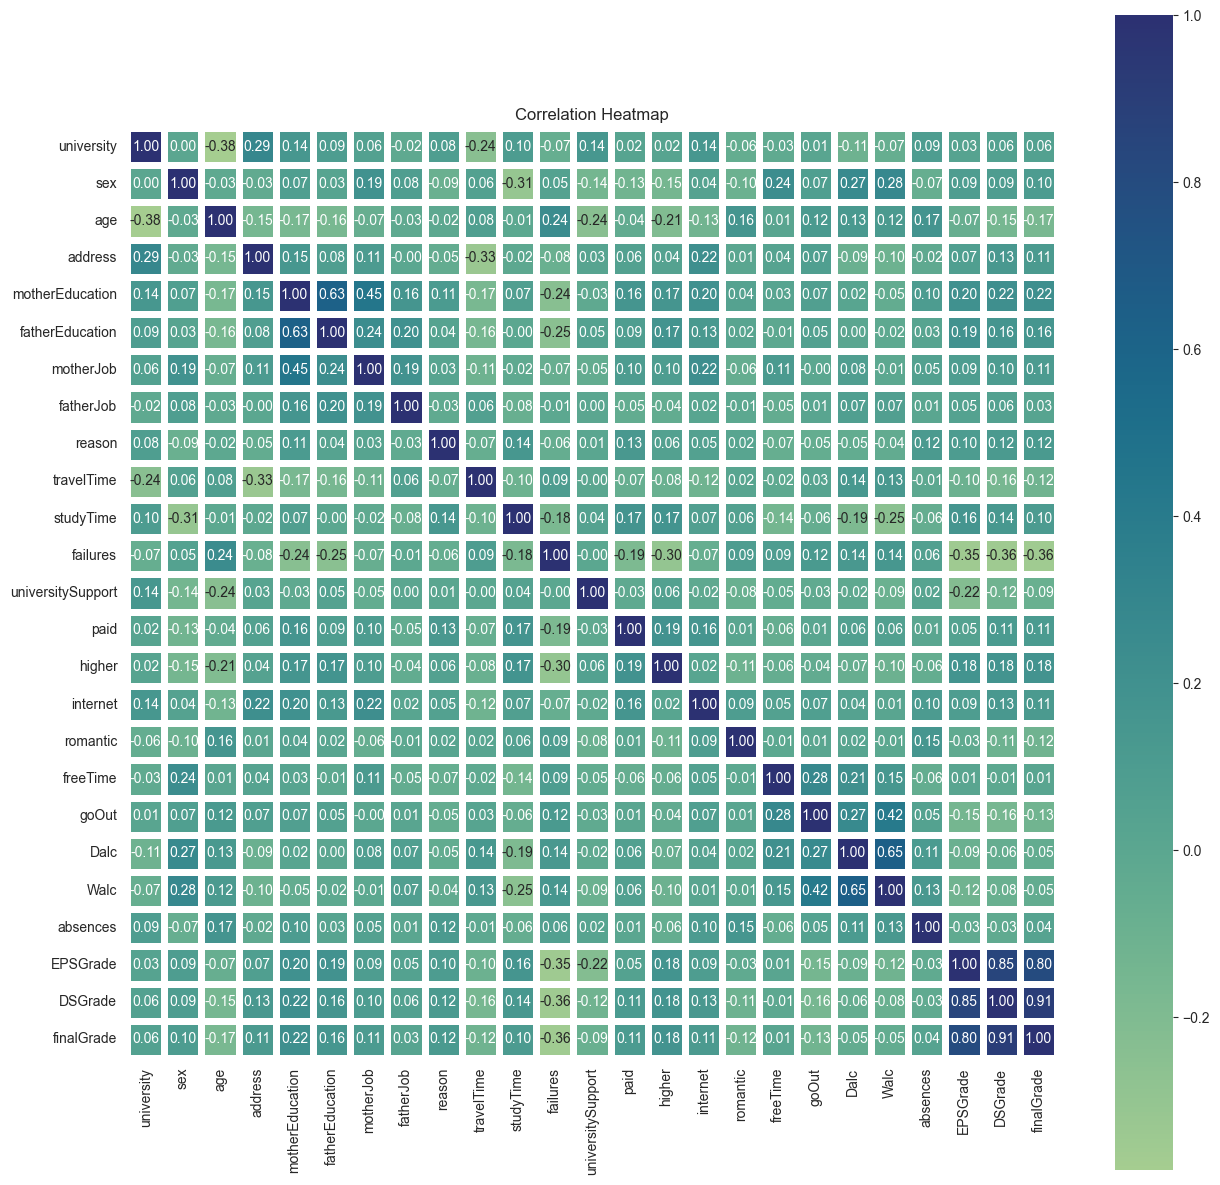

In [4]:
correlation_matrix = df_encoded.corr(method='pearson', numeric_only=True)

sns.set_style('whitegrid')
color_map = sns.color_palette("crest", as_cmap=True)
plt.figure(figsize=(15, 15))
sns.heatmap(
    correlation_matrix, 
    annot=True,
    fmt='.2f', 
    linewidths=5, 
    cbar=True, 
    cmap=color_map, 
    square=True
)
plt.title("Correlation Heatmap")
plt.show()


**<span style="color:pink; font-size:24px;">Handle Unassigned Values</span>**


In [5]:
print('number of unassigned values in 'f"{df.shape[0]} data points")

print((df == 'other').sum())

number of unassigned values in 397 data points
university             0
sex                    0
age                    0
address                0
motherEducation        0
fatherEducation        0
motherJob            142
fatherJob            217
reason                37
travelTime             0
studyTime              0
failures               0
universitySupport      0
paid                   0
higher                 0
internet               0
romantic               0
freeTime               0
goOut                  0
Dalc                   0
Walc                   0
absences               0
EPSGrade               0
DSGrade                0
finalGrade             0
dtype: int64



<span style="font-size:24px; font-weight:bold; color:pink;">About 36% of motherJob and 55% of fatherJob values' are missing, removing these feautures is the best action here</span>


In [6]:
# del df['motherJob']
# del df['fatherJob']
# print((df == 'other').sum())


<span style="font-size:24px; font-weight:bold; color:pink;">Feature Encoding, using one-hot encode is suited for unordered features, although number of colomns increases</span>

>drop first drops the first category alphabetically but the value is still implied, it is only a baseline,
>  
>for example for reasons:  if all dummy columns (reason_home, reason_other, reason_reputation) are false, it means the value was course

In [7]:
df = pd.get_dummies(df, drop_first=True)
print(df)
df.to_csv('df.csv', index=False)


     age  motherEducation  fatherEducation  travelTime  studyTime  failures  \
0     18                4                4           2          2         0   
1     17                1                1           1          2         0   
2     15                1                1           1          2         3   
3     15                4                2           1          3         0   
4     16                3                3           1          2         0   
..   ...              ...              ...         ...        ...       ...   
392   21                1                1           1          1         3   
393   18                3                2           3          1         0   
394   19                1                1           1          1         0   
395   18                4                4           2          2         0   
396   19                1                1           2          1         1   

     freeTime  goOut  Dalc  Walc  ...  fatherJob_se

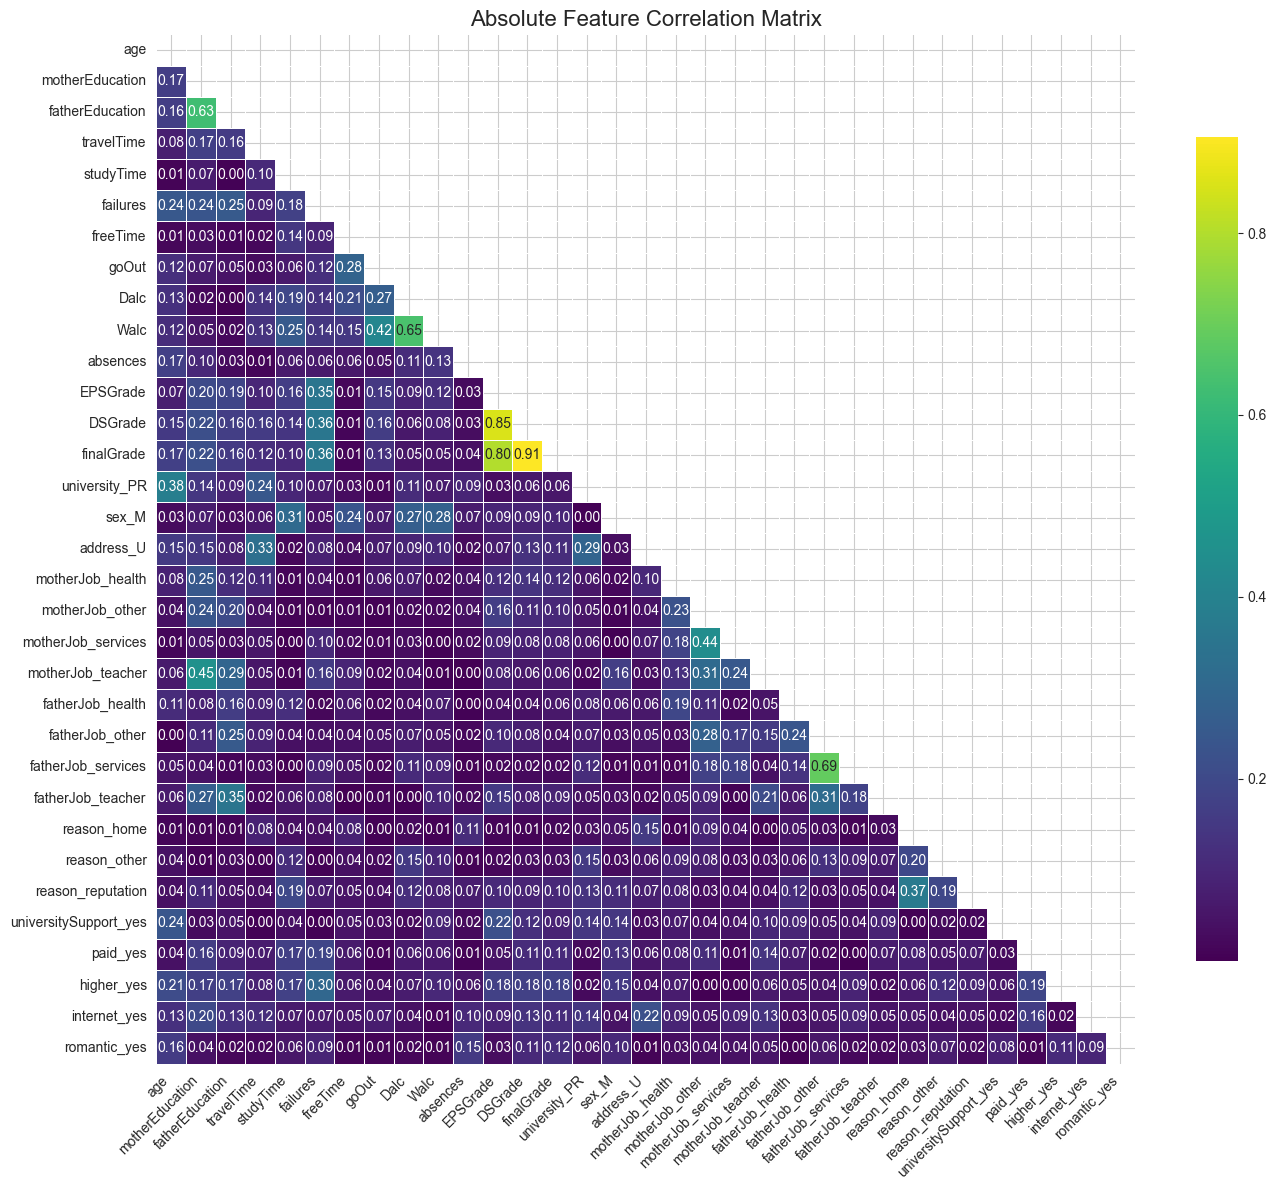

In [8]:
correlation_matrix = df.corr()
# Compute absolute correlation matrix
abs_corr = correlation_matrix.abs()

# Optional: mask upper triangle to reduce redundancy
mask = np.triu(np.ones_like(abs_corr, dtype=bool))

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(
    abs_corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='viridis',       # or use 'rocket', 'magma', 'YlGnBu' for better contrast
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title('Absolute Feature Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [9]:
vec_other = df.corr()['reason_other']
vec_home = df.corr()['reason_home']
vec_reputation = df.corr()['reason_reputation']
# course is baseline → all 0s when others are 0


In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# Convert to numpy arrays and reshape to vectors
v_other = vec_other.drop(['reason_home', 'reason_reputation', 'reason_other']).values.reshape(1, -1)
v_home = vec_home.drop(['reason_home', 'reason_reputation', 'reason_other']).values.reshape(1, -1)
v_reputation = vec_reputation.drop(['reason_home', 'reason_reputation', 'reason_other']).values.reshape(1, -1)

# Compute similarities
sim_home = cosine_similarity(v_other, v_home)[0][0]
sim_reputation = cosine_similarity(v_other, v_reputation)[0][0]

print(f"Similarity to home: {sim_home:.3f}")
print(f"Similarity to reputation: {sim_reputation:.3f}")
print("Assign to:", "home" if sim_home > sim_reputation else "reputation")


Similarity to home: -0.251
Similarity to reputation: -0.433
Assign to: home
